In [97]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# 데이터 호출하기
ts = pd.read_csv('/aiffel/aiffel/stock_prediction/data/005930.KS.csv')

# 데이터 전처리

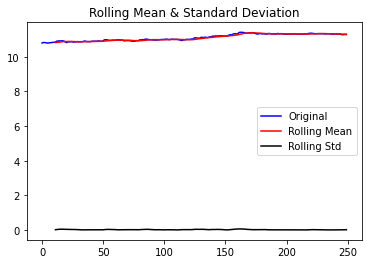

Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [98]:
# 결측치 처리 & 로그변환
ts['Close'].fillna(method='ffill', inplace=True)
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
ts_log = np.log(ts['Close'])  # 'Close' 칼럼만 추출하여 로그 변환 수행

# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dickey-Fuller Test
def augmented_dickey_fuller_test(timeseries):
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

augmented_dickey_fuller_test(ts_log)

# 시계열 분해

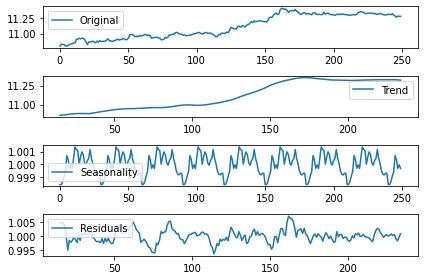

Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


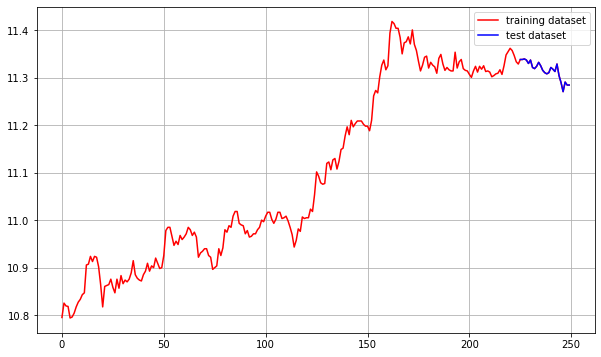

In [99]:
# 시계열 분해 (Time Series Decomposition)을 위한 seasonal_decompose 함수를 불러옵니다.
from statsmodels.tsa.seasonal import seasonal_decompose

# multiplicative 모델을 사용하여 ts_log 시계열 데이터를 분해합니다.
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

# 분해 결과인 trend, seasonal, residual 데이터를 추출합니다.
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# 분해 결과를 그래프로 시각화합니다.
plt.subplot(411)
plt.plot(ts_log)
plt.legend(['Original'], loc='best')

plt.subplot(412)
plt.plot(trend)
plt.legend(['Trend'], loc='best')

plt.subplot(413)
plt.plot(seasonal)
plt.legend(['Seasonality'], loc='best')

plt.subplot(414)
plt.plot(residual)
plt.legend(['Residuals'], loc='best')

plt.tight_layout()
plt.show()

# residual 데이터에서 결측치를 제거합니다.
residual.dropna(inplace=True)

# residual 데이터에 대해 Augmented Dickey-Fuller Test를 수행하여 안정성을 확인합니다.
augmented_dickey_fuller_test(residual)

# train 데이터와 test 데이터로 분리합니다.
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

# 학습 데이터와 테스트 데이터를 그래프로 시각화합니다.
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 차분 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


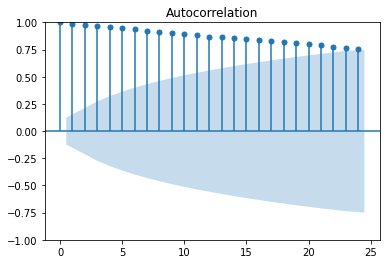

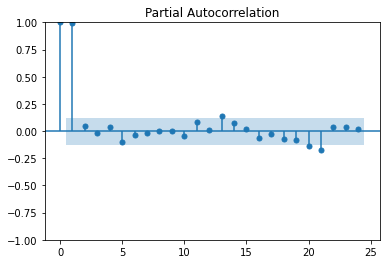

Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


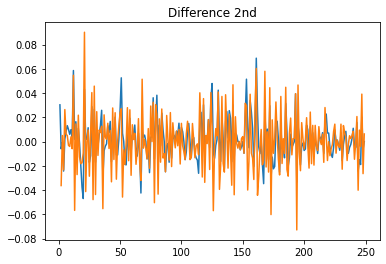

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# ARIMA 모델 학습

In [101]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 03 Apr 2023   AIC                          -1156.722
Time:                        03:17:09   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

# 예측 시각화

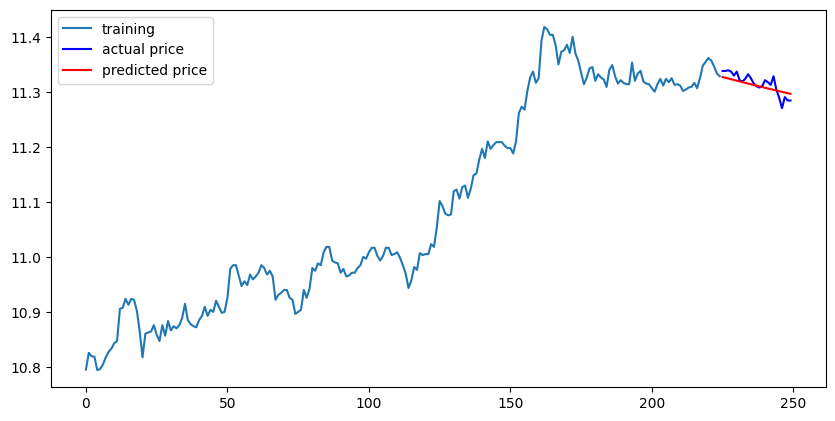

In [102]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()



# 평가지표 출력

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# 아리마모델로 다른 종목 예측&시각화&평가

### 함수화

In [104]:
def arima(ts):
    ts_log = np.log(ts['Close'])

    # train 데이터와 test 데이터로 분리합니다.
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

    from statsmodels.tsa.arima.model import ARIMA

    model = ARIMA(train_data, order=(2, 0, 1))  
    fitted_m = model.fit() 

    print(fitted_m.summary())


    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()


    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import math

    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))



### TSLA

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 602.878
Date:                Mon, 03 Apr 2023   AIC                          -1195.755
Time:                        03:17:18   BIC                          -1178.675
Sample:                             0   HQIC                         -1188.861
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2331      0.035     93.383      0.000       3.165       3.301
ar.L1          1.1211      0.394      2.847      0.004       0.349       1.893
ar.L2         -0.1361      0.384     -0.354      0.7

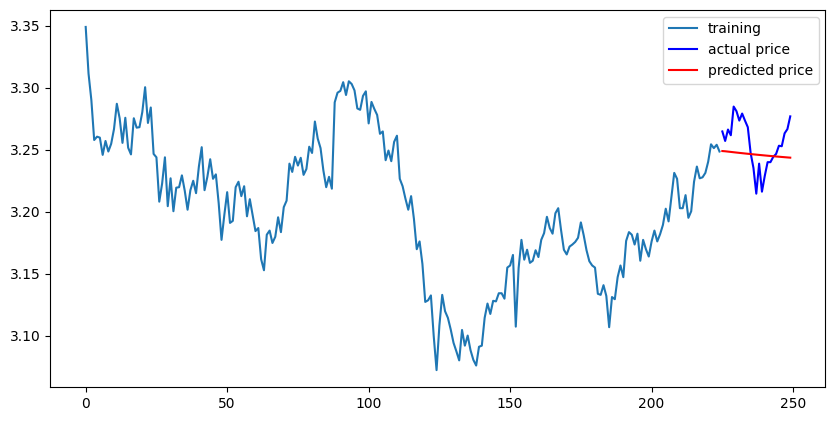

MSE:  0.2858270738533191
MAE:  0.44828800479440234
RMSE:  0.5346279770581774
MAPE: 1.72%


In [105]:
ts = pd.read_csv('/aiffel/aiffel/HMC.csv')
#ts = pd.read_csv('/aiffel/aiffel/TCEHY.csv')
#ts = pd.read_csv('/aiffel/aiffel/TSLA.csv')

arima(ts)

### HMC

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 459.700
Date:                Mon, 03 Apr 2023   AIC                           -909.400
Time:                        03:17:22   BIC                           -892.320
Sample:                             0   HQIC                          -902.506
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7524      0.084     44.518      0.000       3.587       3.918
ar.L1          0.7405      1.875      0.395      0.693      -2.934       4.415
ar.L2          0.2334      1.831      0.127      0.8

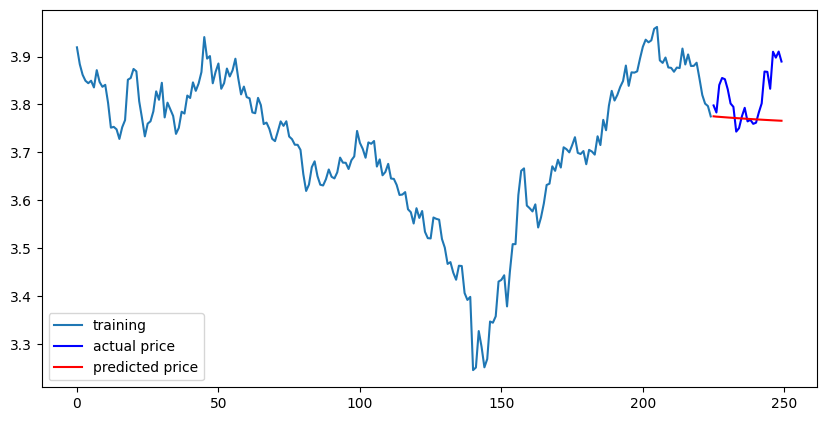

MSE:  10.454331426565497
MAE:  2.4101190609008527
RMSE:  3.2333158562945097
MAPE: 5.07%


In [106]:
#ts = pd.read_csv('aiffel/HMC.csv')
ts = pd.read_csv('/aiffel/aiffel/TCEHY.csv')
#ts = pd.read_csv('/aiffel/aiffel/TSLA.csv')

arima(ts)

### TCEHY

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 386.250
Date:                Mon, 03 Apr 2023   AIC                           -762.499
Time:                        03:17:25   BIC                           -745.419
Sample:                             0   HQIC                          -755.605
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5110      0.189     29.119      0.000       5.140       5.882
ar.L1          0.0423      0.355      0.119      0.905      -0.654       0.738
ar.L2          0.9393      0.356      2.640      0.0

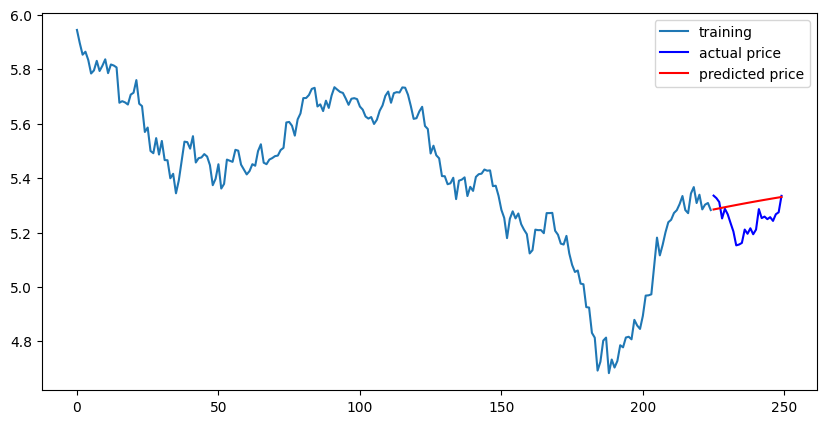

MSE:  253.82320697161774
MAE:  14.005301063183511
RMSE:  15.931829994436224
MAPE: 7.58%


In [107]:
#ts = pd.read_csv('aiffel/HMC.csv')
#ts = pd.read_csv('/aiffel/aiffel/TCEHY.csv')
ts = pd.read_csv('/aiffel/aiffel/TSLA.csv')

arima(ts)